# Project 4 

## Stereo calibration

In [1]:
import cv2 as cv
import numpy as np
import glob

# 定义标定的标准
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
chessboard_size = (9, 6)
square_size = 10

# 创建棋盘格点的世界坐标系
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size

# 定义标定函数并保存内参
def stereo_calibrate(images_cam1, images_cam2, camera_name1, camera_name2):
    assert len(images_cam1) == len(images_cam2), f"The number of images from {camera_name1} and {camera_name2} should be the same"

    objpoints = []  # 世界坐标系中的3D点
    imgpoints_cam1 = []  # 相机1的图像坐标系中的2D点
    imgpoints_cam2 = []  # 相机2的图像坐标系中的2D点

    # 处理每对图像
    for img_cam1, img_cam2 in zip(images_cam1, images_cam2):
        img1 = cv.imread(img_cam1)
        img2 = cv.imread(img_cam2)
        gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

        ret1, corners1 = cv.findChessboardCorners(gray1, chessboard_size, None)
        ret2, corners2 = cv.findChessboardCorners(gray2, chessboard_size, None)

        # 如果两个相机都找到了角点，才继续处理
        if ret1 and ret2:
            objpoints.append(objp)

            # 提高角点精度
            corners1 = cv.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
            corners2 = cv.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)

            imgpoints_cam1.append(corners1)
            imgpoints_cam2.append(corners2)

            # 绘制角点
            cv.drawChessboardCorners(img1, chessboard_size, corners1, ret1)
            cv.drawChessboardCorners(img2, chessboard_size, corners2, ret2)
            cv.imshow(f'Corners {camera_name1}', img1)
            cv.imshow(f'Corners {camera_name2}', img2)
            
            # 按键控制：按 'q' 键退出，按任意键继续
            if cv.waitKey(500) & 0xFF == ord('q'):
                break

    cv.destroyAllWindows()

    # 标定两个相机
    ret1, mtx1, dist1, _, _ = cv.calibrateCamera(objpoints, imgpoints_cam1, gray1.shape[::-1], None, None)
    ret2, mtx2, dist2, _, _ = cv.calibrateCamera(objpoints, imgpoints_cam2, gray2.shape[::-1], None, None)

    # 立体标定
    flags = cv.CALIB_FIX_INTRINSIC
    ret, _, _, _, _, R, T, E, F = cv.stereoCalibrate(
        objpoints, imgpoints_cam1, imgpoints_cam2, 
        mtx1, dist1, mtx2, dist2, gray1.shape[::-1], criteria=criteria, flags=flags)

    # 输出标定结果
    print(f"Rotation matrix R between {camera_name1} and {camera_name2}:\n{R}")
    print(f"Translation matrix T between {camera_name1} and {camera_name2}:\n{T}")

    # 保存内参和畸变系数到文件
    # np.savez(f'{save_path}/{camera_name1}_{camera_name2}_calibration.npz',
    #          mtx1=mtx1, dist1=dist1, mtx2=mtx2, dist2=dist2, R=R, T=T, E=E, F=F)

    return mtx1, dist1, mtx2, dist2, R, T

# 加载左-中和右-中相机的图像
images_left = glob.glob('./Calibratie 1/calibrationLeft/*.jpg')
images_middle = glob.glob('./Calibratie 1/calibrationMiddle/*.jpg')
images_right = glob.glob('./Calibratie 1/calibrationRight/*.jpg')

# 创建保存路径
# save_path = './calibration_results'
# if not os.path.exists(save_path):
#     os.makedirs(save_path)

# 对左-中相机进行立体标定并保存内参
print("Calibrating Left-Middle Cameras...")
mtxL, distL, mtxM_L, distM_L, R_LM, T_LM = stereo_calibrate(images_left, images_middle, "Left", "Middle")

# 对右-中相机进行立体标定并保存内参
print("Calibrating Right-Middle Cameras...")
mtxR, distR, mtxM_R, distM_R, R_RM, T_RM = stereo_calibrate(images_right, images_middle, "Right", "Middle")

# 对左-右相机进行立体标定并保存内参
print("Calibrating Left-Right Cameras...")
mtxL, distL, mtxR, distR, R_LR, T_LR = stereo_calibrate(images_left, images_right, "Left", "Right")


mtxM = mtxM_L

Calibrating Left-Middle Cameras...
Rotation matrix R between Left and Middle:
[[ 0.9410177  -0.00334044  0.33834086]
 [ 0.0065685   0.99994318 -0.00839634]
 [-0.33829358  0.0101235   0.94098617]]
Translation matrix T between Left and Middle:
[[-107.76511073]
 [   3.37846172]
 [  41.51736467]]
Calibrating Right-Middle Cameras...
Rotation matrix R between Right and Middle:
[[ 9.40500962e-01  5.60457121e-03 -3.39744800e-01]
 [-5.75558940e-03  9.99983278e-01  5.63187787e-04]
 [ 3.39742275e-01  1.42575291e-03  9.40517492e-01]]
Translation matrix T between Right and Middle:
[[105.06557542]
 [ -0.69439235]
 [ 43.62895773]]
Calibrating Left-Right Cameras...
Rotation matrix R between Left and Right:
[[ 0.76767669 -0.00929143  0.64076998]
 [ 0.01358079  0.99990621 -0.00177146]
 [-0.64069342  0.01006207  0.76773087]]
Translation matrix T between Left and Right:
[[-201.67086621]
 [   1.55794469]
 [  69.97655445]]


In [ ]:
import cv2 as cv
import dlib
import numpy as np

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") 

# create a VideoCapture object
cap = cv.VideoCapture('./subject1/proefpersoon 1.2_L.avi') 

# 光流法参数
lk_params = dict(winSize=(20, 20), maxLevel=2, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 20, 0.03))

# 检查视频是否打开成功
if not cap.isOpened():
    print("can't open the video")
    exit()

# 开启文件写入模式
with open("./Points/tongue_LeftTracking_L1_2_test.txt", "w") as log_file:
    # log_file.write("Frame	Tongue_X	Tongue_Y\n")

    # 变量控制播放状态
    paused = False
    tongue_visible = False
    tongue_point = None
    prev_tongue_point = None

    # 定义一些距离阀值
    mouth_open_threshold = 203  # 检测嘴巴是否张开
    mouth_close_threshold = 175  # 检测嘴巴是否关闭
    tongue_movement_threshold = 30  # 舌尖移动距离过大的阀值
    tongue_movement_min_threshold = 0.01  # 舌尖移动距离过小的阀值

    # 帧数计数器
    frame_counter = 0
    check_frames_interval = 20  # 每隔20帧检查一次
    check_tracking = True  
    frame_cnt = 0

    # 定义函数手动选择舌尖点
    def select_tongue_point(frame):
        roi = cv.selectROI("Select Tongue Point", frame, fromCenter=False, showCrosshair=True)
        cv.destroyAllWindows()
        x = int(roi[0] + roi[2] / 2)
        y = int(roi[1] + roi[3] / 2)
        return np.array([[x, y]], dtype=np.float32).reshape(-1, 1, 2)

    # 开始读取视频
    while cap.isOpened():
        frame_cnt += 1
        if not paused:  # 只有在未暂停时读取下一帧
            ret, frame = cap.read()
            if not ret:
                break

            # 转换为灰度图像，dlib 的人脸检测器需要灰度图像
            gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

            # 使用 dlib 检测人脸
            faces = detector(gray_frame)

            # 遍历检测到的每一张人脸
            for face in faces:
                # 获取 68 个面部特征点
                landmarks = predictor(gray_frame, face)

                # 绘制每个特征点
                for i in range(68):
                    x = landmarks.part(i).x
                    y = landmarks.part(i).y
                    cv.circle(frame, (x, y), 2, (0, 255, 0), -1)  # 绿色标记所有特征点

                # 获取第51个和第8个特征点的坐标
                x_51, y_51 = landmarks.part(51).x, landmarks.part(51).y  # 第51个特征点
                x_8, y_8 = landmarks.part(8).x, landmarks.part(8).y  # 第8个特征点
                
                # 计算两个特征点之间的欧氏距离
                distance = np.sqrt((x_51 - x_8) ** 2 + (y_51 - y_8) ** 2)

                # 在视频帧上显示距离
                cv.putText(frame, f"Dist: {distance:.2f} Frame: {frame_cnt}", (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
                cv.line(frame, (x_51, y_51), (x_8, y_8), (0, 0, 255), 2)

                # 判断是否需要手动标记舌尖点
                if distance > mouth_open_threshold and not tongue_visible:
                    # 提示用户是否看到了舌尖点
                    print("we detect the mouth is open，do you see the tip of the tongue？ (y/n)")
                    user_input = input().strip().lower()
                    if user_input == 'y':
                        # 暂停视频，手动选择舌尖点
                        paused = True
                        tongue_point = select_tongue_point(frame)  # 手动选择舌尖
                        tongue_visible = True
                        prev_tongue_point = tongue_point.copy()
                        paused = False

                # 如果舌尖点存在且嘴巴闭合，提示用户是否要清除舌尖点
                if tongue_visible and distance < mouth_close_threshold:
                    print("we detect the mouth is closed，do you see the mouth is closed？ (y/n)")
                    user_input = input().strip().lower()
                    if user_input == 'y':
                        tongue_visible = False
                        tongue_point = None
                        # 提示用户是否要更新阀值
                        print("Update the threshold？ (y/n)")
                        user_input = input().strip().lower()
                        if user_input == 'y':
                            print("Input the new threshold：")  # 最好更新为194
                            mouth_open_threshold = int(input().strip())

                # 如果舌尖点存在，使用光流法跟踪舌尖
                if tongue_visible and tongue_point is not None:
                    # 使用光流法追踪舌尖
                    tongue_point_curr, st, err = cv.calcOpticalFlowPyrLK(prev_gray, gray_frame, tongue_point, None, **lk_params)

                    # 检查光流法是否有效且点被成功追踪（st值为1表示成功追踪）
                    if tongue_point_curr is not None and st[0][0] == 1:
                        tongue_point = tongue_point_curr  # 更新舌尖点位置
                        tongue_x, tongue_y = tongue_point.ravel()

                        # 检查舌尖的移动是否过大
                        tongue_movement = np.linalg.norm(tongue_point - prev_tongue_point)
                        if tongue_movement > tongue_movement_threshold:
                            # 如果舌尖移动过大，暂停视频并提示用户
                            paused = True
                            print("Always select yes in the part？ (y/n)")
                            user_input = input().strip().lower()
                            if user_input == 'y':
                                # 用户确认出错，重新标记舌尖
                                tongue_point = select_tongue_point(frame)
                            prev_tongue_point = tongue_point.copy()
                            paused = False
                        elif tongue_movement <= tongue_movement_min_threshold:
                            # 如果舌尖移动过小，暂停视频并提示用户
                            paused = True
                            print("the movement of the tip is too low，is it an error？ (y/n)")
                            user_input = input().strip().lower()
                            if user_input == 'y':
                                # 用户确认出错，重新标记舌尖
                                tongue_point = select_tongue_point(frame)
                            prev_tongue_point = tongue_point.copy()
                            paused = False
                        else:
                            prev_tongue_point = tongue_point.copy()
                        
                        # 将当前帧号和舌尖坐标写入文件
                        log_file.write(f"{frame_cnt} {int(tongue_x)} {int(tongue_y)}\n")

                        # 每隔20帧检查一次追踪点是否正确
                        if check_tracking:
                            frame_counter += 1
                            if frame_counter >= check_frames_interval:
                                paused = True
                                print("Is the tracking correct？ (y/n)")
                                user_input = input().strip().lower()
                                if user_input == 'n':
                                    # 用户确认出错，重新标记舌尖
                                    tongue_point = select_tongue_point(frame)
                                elif user_input == 'y':
                                    # 用户确认正确，停止每隔10帧提示
                                    check_tracking = False
                                frame_counter = 0  # 重置帧计数器
                                paused = False

                        cv.circle(frame, (int(tongue_x), int(tongue_y)), 5, (0, 0, 255), -1)  # 红色标记舌尖

        # 显示处理后的每一帧
        cv.imshow('Face and Tongue Tracking', frame)

        # 检测键盘按键
        key = cv.waitKey(10) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('p'): 
            paused = True
            print("Is tracking wrong？ (y/n)")
            user_input = input().strip().lower()
            if user_input == 'y':
                tongue_point = select_tongue_point(frame)
                paused = False
        elif key == ord('c'): 
            paused = False

        prev_gray = gray_frame.copy()  

# 释放视频捕捉对象并关闭所有窗口
cap.release()
cv.destroyAllWindows()


## save tongue point(do not need to run in the second time)

In [ ]:
import cv2 as cv
import numpy as np

# 读取舌尖点数据文件，格式为 frame, x, y
def load_points(file_name):
    points = {}
    with open(file_name, 'r') as f:
        for line in f:
            frame, x, y = line.strip().split()
            points[int(frame)] = (float(x), float(y))
    return points

# 三角测量得到3D点
def triangulate_points(cam1_pts, cam2_pts, P1, P2):
    # 将2D点转换为 (2, N) 形状的数组，N为1
    cam1_pts_hom = np.array([[cam1_pts[0]], [cam1_pts[1]]])
    cam2_pts_hom = np.array([[cam2_pts[0]], [cam2_pts[1]]])
    
    # 使用OpenCV的triangulatePoints函数进行三角测量
    points_4d = cv.triangulatePoints(P1, P2, cam1_pts_hom, cam2_pts_hom)
    
    # 转换为3D坐标（非齐次）
    points_3d = points_4d[:3] / points_4d[3]
    return points_3d.flatten()

# 计算投影矩阵
def projection_matrix(mtx, R, T):
    return np.dot(mtx, np.hstack((R, T)))

# 加载标定的相机参数
# 这里使用你之前得到的标定结果
# 例如左-中相机的旋转矩阵和平移向量R_LM, T_LM
# 右-中相机的旋转矩阵和平移向量R_RM, T_RM
# 以及相机的内参矩阵和畸变系数
# mtxL, mtxM, mtxR = ... 
# R_LM, T_LM = ...  
# R_RM, T_RM = ...  

# 计算左-中相机对的投影矩阵
P_left_middle = projection_matrix(mtxL, np.eye(3), np.zeros((3, 1)))
P_middle_left = projection_matrix(mtxM, R_LM, T_LM)

# 计算右-中相机对的投影矩阵
P_right_middle = projection_matrix(mtxR, np.eye(3), np.zeros((3, 1)))
P_middle_right = projection_matrix(mtxM, R_RM, T_RM)

# 读取三个文件中舌尖点的数据
left_points = load_points('./Points/tongue_LeftTracking_L1.txt')
middle_points = load_points('./Points/tongue_MiddleTracking_M1.txt')
right_points = load_points('./Points/tongue_MiddleTracking_R1.txt')

# 找到三个文件中相同帧的数据
common_frames = set(left_points.keys()) & set(middle_points.keys()) & set(right_points.keys())

# 存储3D结果
output_3d_pointsLM = {}
output_3d_pointsRM = {}
output_3d_pointsLR = {}

# 对每一帧计算舌尖的3D坐标
for frame in common_frames:
    # 获取左、中、右相机的2D点
    left_pt = left_points[frame]
    middle_pt = middle_points[frame]
    right_pt = right_points[frame]

    # 对左-中相机对进行三角测量
    point_3d_left_middle = triangulate_points(left_pt, middle_pt, P_left_middle, P_middle_left)

    # 对右-中相机对进行三角测量
    point_3d_right_middle = triangulate_points(right_pt, middle_pt, P_right_middle, P_middle_right)

    # 对左-右相机对进行三角测量
    point_3d_left_right = triangulate_points(left_pt, right_pt, P_left_middle, P_middle_right)

    # 存储结果
    point_3d_LM = (point_3d_left_middle)
    point_3d_RM = (point_3d_right_middle)
    point_3d_LR = (point_3d_left_right)

    # 存储结果
    output_3d_pointsLM[frame] = point_3d_LM
    output_3d_pointsRM[frame] = point_3d_RM
    output_3d_pointsLR[frame] = point_3d_LR

# 将结果保存到文件中
with open('./tongue_3d_pointsLM.txt', 'w') as f:
    for frame, point_3d in output_3d_pointsLM.items():
        f.write(f"{frame} {point_3d[0]} {point_3d[1]} {point_3d[2]}\n")

with open('./tongue_3d_pointsRM.txt', 'w') as f:
    for frame, point_3d in output_3d_pointsRM.items():
        f.write(f"{frame} {point_3d[0]} {point_3d[1]} {point_3d[2]}\n")

with open('./tongue_3d_pointsLR.txt', 'w') as f:
    for frame, point_3d in output_3d_pointsLR.items():
        f.write(f"{frame} {point_3d[0]} {point_3d[1]} {point_3d[2]}\n")

print("3D points saved successfully.")


In [ ]:
def select_points(img):
    points = cv.selectROIs("Select Points", img, fromCenter=False, showCrosshair=True)
    points = [(int(p[0] + p[2] / 2), int(p[1] + p[3] / 2)) for p in points]  # 获取每个ROI的中心点
    return points

# 读取标记点视频的第一帧，手动初始化面部标志点和舌尖点
cap_marked = cv.VideoCapture('./subject1/proefpersoon 1.2_M.avi')
ret, first_frame = cap_marked.read()

if ret:
    # 手动选择标志点 (如鼻尖、眼角、舌尖等)
    print("请手动选择面部标志点和舌尖...")
    marked_landmarks = select_points(first_frame)
    print(f"选择的点坐标：{marked_landmarks}")

cv.destroyAllWindows()
cap_marked.release()

### some landmarks point(do not need to run in the second time)
- Left
    - forehead point (293, 338)
    - nose point (325, 461)
    - right cheek point (148, 432)
    - left cheek point (422, 430)
- Right
    - forehead point (746, 319)
    - nose point (743, 442)
    - right cheek point (620, 418)
    - left cheek point (896, 409)
- Middle
    - forehead point (513, 314)
    - nose point (527, 429)
    - right cheek point (384, 406)
    - left cheek point (646, 399)

In [ ]:
import cv2 as cv
import numpy as np

# in the code, what you should do is to change the folder path.(I can provide the txt file for you)


# 定义视频文件路径
frame_cnt = 0
video_path = './subject1/proefpersoon 1.2_M.avi'  # 替换为你的实际视频文件路径

# 指定要跟踪的面部特征点
points_to_track = {
    'Forehead': (513, 314),
    'Nose Tip': (527, 429),
    'Right Cheek': (384, 406),
    'Left Cheek': (646, 399)
}

# 打开视频文件
cap = cv.VideoCapture(video_path)

# 检查视频是否成功打开
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# 打开文件，分别保存特征点
forehead_file = open("./Points/LandmarksMiddle/forehead_points.txt", "w") # LandmarksMiddle
nose_file = open("./Points/LandmarksMiddle/nose_tip_points.txt", "w")
right_cheek_file = open("./Points/LandmarksMiddle/right_cheek_points.txt", "w")
left_cheek_file = open("./Points/LandmarksMiddle/left_cheek_points.txt", "w")

# 读取第一帧
ret, first_frame = cap.read()
if not ret:
    print("Error: Could not read frame.")
    exit()

# 转换为灰度图像
gray_first_frame = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

# 存储指定的点并绘制这些点
initial_points = np.array(list(points_to_track.values()), dtype=np.float32).reshape(-1, 1, 2)
for point_name, (x, y) in points_to_track.items():
    cv.circle(first_frame, (x, y), 5, (0, 255, 0), -1)  # 在第一帧上绘制点
    cv.putText(first_frame, point_name, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# 显示第一帧上的标记点
cv.imshow("First Frame with Points", first_frame)
cv.waitKey(0)  # 按任意键继续

# 设置光流参数
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# 初始化前一帧的灰度图像和跟踪点
prev_gray_frame = gray_first_frame.copy()
prev_points = initial_points.copy()

# 跟踪点
while True:
    frame_cnt += 1
    ret, frame = cap.read()
    if not ret:
        break

    # 转换为灰度图像
    gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # 计算光流
    new_points, status, error = cv.calcOpticalFlowPyrLK(prev_gray_frame, gray_frame, prev_points, None, **lk_params)

    # 检查光流计算结果是否有效
    if new_points is not None and status is not None:
        # 只选择有效的点
        good_new = new_points[status.flatten() == 1]
        good_old = prev_points[status.flatten() == 1]

        # 在视频帧上绘制跟踪结果并保存到文件中
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            # 将坐标转换为整数类型
            a, b, c, d = int(a), int(b), int(c), int(d)
            
            cv.circle(frame, (a, b), 5, (0, 255, 0), -1)  # 绘制新位置
            cv.line(frame, (a, b), (c, d), (255, 0, 0), 2)  # 绘制旧位置到新位置的连线
            cv.putText(frame, list(points_to_track.keys())[i], (a, b - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            # 根据点的索引将对应的坐标写入不同的文件
            if i == 0:  # Forehead
                forehead_file.write(f"{frame_cnt} {a} {b}\n")
            elif i == 1:  # Nose Tip
                nose_file.write(f"{frame_cnt} {a} {b}\n")
            elif i == 2:  # Right Cheek
                right_cheek_file.write(f"{frame_cnt} {a} {b}\n")
            elif i == 3:  # Left Cheek
                left_cheek_file.write(f"{frame_cnt} {a} {b}\n")

        # 更新有效的点
        prev_points = good_new.reshape(-1, 1, 2)
        prev_gray_frame = gray_frame.copy()  # 更新前一帧的灰度图像

    # 显示视频帧
    cv.imshow("Tracking Points", frame)

    # 按 'q' 键退出
    if cv.waitKey(30) & 0xFF == ord('q'):
        break

# 释放视频捕捉对象并关闭所有窗口
cap.release()
cv.destroyAllWindows()

# 关闭文件
forehead_file.close()
nose_file.close()
right_cheek_file.close()
left_cheek_file.close()


## save 3D landmarks(do not need to run in the second time)

In [ ]:

def load_2d_points(file_path):
    points = {}
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y = line.strip().split()
            points[int(frame)] = np.array([float(x), float(y)])
    return points

file_name_left = 'Points/LandmarksLeft/forehead_points.txt'
file_name_middle = 'Points/LandmarksMiddle/forehead_points.txt'
file_name_right = 'Points/LandmarksRight/forehead_points.txt'

forehead_points_left = load_2d_points(file_name_left)
forehead_points_middle = load_2d_points(file_name_middle)
forehead_points_right = load_2d_points(file_name_right)

common_frames = set(forehead_points_left.keys()) & set(forehead_points_middle.keys()) & set(forehead_points_right.keys())

output_3d_forehead_pointsLM = {}
output_3d_forehead_pointsRM = {}
output_3d_forehead_pointsLR = {}

# 将2D点转换为三维坐标
for frame in common_frames:
    left_pt = forehead_points_left[frame]
    middle_pt = forehead_points_middle[frame]
    right_pt = forehead_points_right[frame]

    # 将2D点转换为齐次坐标 (homogeneous coordinates)
    left_pt_hom = np.array([[left_pt[0]], [left_pt[1]], [1]], dtype=np.float32)
    middle_pt_hom = np.array([[middle_pt[0]], [middle_pt[1]], [1]], dtype=np.float32)
    right_pt_hom = np.array([[right_pt[0]], [right_pt[1]], [1]], dtype=np.float32)

    # 使用 cv2.triangulatePoints 计算 3D 坐标
    # 1. 计算左-中 3D 坐标
    points_4d_LM = cv.triangulatePoints(mtxL @ np.hstack((R_LM, T_LM.reshape(-1, 1))),
                                        mtxM @ np.hstack((np.eye(3), np.zeros((3, 1)))), 
                                        left_pt_hom[:2], middle_pt_hom[:2])

    # 2. 计算右-中 3D 坐标
    points_4d_RM = cv.triangulatePoints(mtxR @ np.hstack((R_RM, T_RM.reshape(-1, 1))),
                                        mtxM @ np.hstack((np.eye(3), np.zeros((3, 1)))), 
                                        right_pt_hom[:2], middle_pt_hom[:2])

    # 3. 计算左-右 3D 坐标
    points_4d_LR = cv.triangulatePoints(mtxL @ np.hstack((np.eye(3), np.zeros((3, 1)))),
                                        mtxR @ np.hstack((R_LR, T_LR.reshape(-1, 1))), 
                                        left_pt_hom[:2], right_pt_hom[:2])


    # 齐次坐标转换为非齐次坐标
    point_3d_LM = points_4d_LM[:3] / points_4d_LM[3]
    point_3d_RM = points_4d_RM[:3] / points_4d_RM[3]
    point_3d_LR = points_4d_LR[:3] / points_4d_LR[3]

    # 存储结果
    output_3d_forehead_pointsLM[frame] = point_3d_LM.flatten()
    output_3d_forehead_pointsRM[frame] = point_3d_RM.flatten()
    output_3d_forehead_pointsLR[frame] = point_3d_LR.flatten()

# 保存结果到文件
with open('./Points/3d_forehead_points_LM.txt', 'w') as f:
    for frame, point in output_3d_forehead_pointsLM.items():
        f.write(f"{frame} {point[0]} {point[1]} {point[2]}\n")

with open('./Points/3d_forehead_points_RM.txt', 'w') as f:
    for frame, point in output_3d_forehead_pointsRM.items():
        f.write(f"{frame} {point[0]} {point[1]} {point[2]}\n")

with open('./Points/3d_forehead_points_LR.txt', 'w') as f:
    for frame, point in output_3d_forehead_pointsLR.items():
        f.write(f"{frame} {point[0]} {point[1]} {point[2]}\n")
    

In [ ]:

def load_2d_points(file_path):
    points = {}
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y = line.strip().split()
            points[int(frame)] = np.array([float(x), float(y)])
    return points

file_name_left = 'Points/LandmarksLeft/nose_tip_points.txt'
file_name_middle = 'Points/LandmarksMiddle/nose_tip_points.txt'
file_name_right = 'Points/LandmarksRight/nose_tip_points.txt'

forehead_points_left = load_2d_points(file_name_left)
forehead_points_middle = load_2d_points(file_name_middle)
forehead_points_right = load_2d_points(file_name_right)

common_frames = set(forehead_points_left.keys()) & set(forehead_points_middle.keys()) & set(forehead_points_right.keys())

output_3d_forehead_pointsLM = {}
output_3d_forehead_pointsRM = {}
output_3d_forehead_pointsLR = {}

# 将2D点转换为三维坐标
for frame in common_frames:
    left_pt = forehead_points_left[frame]
    middle_pt = forehead_points_middle[frame]
    right_pt = forehead_points_right[frame]

    # 将2D点转换为齐次坐标 (homogeneous coordinates)
    left_pt_hom = np.array([[left_pt[0]], [left_pt[1]], [1]], dtype=np.float32)
    middle_pt_hom = np.array([[middle_pt[0]], [middle_pt[1]], [1]], dtype=np.float32)
    right_pt_hom = np.array([[right_pt[0]], [right_pt[1]], [1]], dtype=np.float32)

    # 使用 cv2.triangulatePoints 计算 3D 坐标
    # 1. 计算左-中 3D 坐标
    points_4d_LM = cv.triangulatePoints(mtxL @ np.hstack((R_LM, T_LM.reshape(-1, 1))),
                                        mtxM @ np.hstack((np.eye(3), np.zeros((3, 1)))), 
                                        left_pt_hom[:2], middle_pt_hom[:2])

    # 2. 计算右-中 3D 坐标
    points_4d_RM = cv.triangulatePoints(mtxR @ np.hstack((R_RM, T_RM.reshape(-1, 1))),
                                        mtxM @ np.hstack((np.eye(3), np.zeros((3, 1)))), 
                                        right_pt_hom[:2], middle_pt_hom[:2])

    # 3. 计算左-右 3D 坐标
    points_4d_LR = cv.triangulatePoints(mtxL @ np.hstack((np.eye(3), np.zeros((3, 1)))),
                                        mtxR @ np.hstack((R_LR, T_LR.reshape(-1, 1))), 
                                        left_pt_hom[:2], right_pt_hom[:2])


    # 齐次坐标转换为非齐次坐标
    point_3d_LM = points_4d_LM[:3] / points_4d_LM[3]
    point_3d_RM = points_4d_RM[:3] / points_4d_RM[3]
    point_3d_LR = points_4d_LR[:3] / points_4d_LR[3]

    # 存储结果
    output_3d_forehead_pointsLM[frame] = point_3d_LM.flatten()
    output_3d_forehead_pointsRM[frame] = point_3d_RM.flatten()
    output_3d_forehead_pointsLR[frame] = point_3d_LR.flatten()

# 保存结果到文件
with open('./Points/3d_nose_points_LM.txt', 'w') as f:
    for frame, point in output_3d_forehead_pointsLM.items():
        f.write(f"{frame} {point[0]} {point[1]} {point[2]}\n")

with open('./Points/3d_nose_points_RM.txt', 'w') as f:
    for frame, point in output_3d_forehead_pointsRM.items():
        f.write(f"{frame} {point[0]} {point[1]} {point[2]}\n")

with open('./Points/3d_nose_points_LR.txt', 'w') as f:
    for frame, point in output_3d_forehead_pointsLR.items():
        f.write(f"{frame} {point[0]} {point[1]} {point[2]}\n")
    

In [ ]:
# when you want to save the 3D points of the left cheek, you just replace the file name with the correct one
def load_2d_points(file_path):
    points = {}
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y = line.strip().split()
            points[int(frame)] = np.array([float(x), float(y)])
    return points

file_name_left = 'Points/LandmarksLeft/right_cheek_points.txt'
file_name_middle = 'Points/LandmarksMiddle/right_cheek_points.txt'
file_name_right = 'Points/LandmarksRight/right_cheek_points.txt'

forehead_points_left = load_2d_points(file_name_left)
forehead_points_middle = load_2d_points(file_name_middle)
forehead_points_right = load_2d_points(file_name_right)

common_frames = set(forehead_points_left.keys()) & set(forehead_points_middle.keys()) & set(forehead_points_right.keys())

output_3d_forehead_pointsLM = {}
output_3d_forehead_pointsRM = {}
output_3d_forehead_pointsLR = {}

# 将2D点转换为三维坐标
for frame in common_frames:
    left_pt = forehead_points_left[frame]
    middle_pt = forehead_points_middle[frame]
    right_pt = forehead_points_right[frame]

    # 将2D点转换为齐次坐标 (homogeneous coordinates)
    left_pt_hom = np.array([[left_pt[0]], [left_pt[1]], [1]], dtype=np.float32)
    middle_pt_hom = np.array([[middle_pt[0]], [middle_pt[1]], [1]], dtype=np.float32)
    right_pt_hom = np.array([[right_pt[0]], [right_pt[1]], [1]], dtype=np.float32)

    # 使用 cv2.triangulatePoints 计算 3D 坐标
    # 1. 计算左-中 3D 坐标
    points_4d_LM = cv.triangulatePoints(mtxL @ np.hstack((R_LM, T_LM.reshape(-1, 1))),
                                        mtxM @ np.hstack((np.eye(3), np.zeros((3, 1)))), 
                                        left_pt_hom[:2], middle_pt_hom[:2])

    # 2. 计算右-中 3D 坐标
    points_4d_RM = cv.triangulatePoints(mtxR @ np.hstack((R_RM, T_RM.reshape(-1, 1))),
                                        mtxM @ np.hstack((np.eye(3), np.zeros((3, 1)))), 
                                        right_pt_hom[:2], middle_pt_hom[:2])

    # 3. 计算左-右 3D 坐标
    points_4d_LR = cv.triangulatePoints(mtxL @ np.hstack((np.eye(3), np.zeros((3, 1)))),
                                        mtxR @ np.hstack((R_LR, T_LR.reshape(-1, 1))), 
                                        left_pt_hom[:2], right_pt_hom[:2])


    # 齐次坐标转换为非齐次坐标
    point_3d_LM = points_4d_LM[:3] / points_4d_LM[3]
    point_3d_RM = points_4d_RM[:3] / points_4d_RM[3]
    point_3d_LR = points_4d_LR[:3] / points_4d_LR[3]

    # 存储结果
    output_3d_forehead_pointsLM[frame] = point_3d_LM.flatten()
    output_3d_forehead_pointsRM[frame] = point_3d_RM.flatten()
    output_3d_forehead_pointsLR[frame] = point_3d_LR.flatten()

# 保存结果到文件
with open('./Points/3d_right_cheek_points_LM.txt', 'w') as f:
    for frame, point in output_3d_forehead_pointsLM.items():
        f.write(f"{frame} {point[0]} {point[1]} {point[2]}\n")

with open('./Points/3d_right_cheek_points_RM.txt', 'w') as f:
    for frame, point in output_3d_forehead_pointsRM.items():
        f.write(f"{frame} {point[0]} {point[1]} {point[2]}\n")

with open('./Points/3d_right_cheek_points_LR.txt', 'w') as f:
    for frame, point in output_3d_forehead_pointsLR.items():
        f.write(f"{frame} {point[0]} {point[1]} {point[2]}\n")
    

## show the track of point in world coordinate system


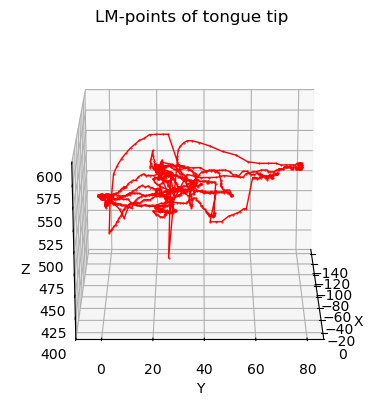

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

# 定义函数来加载3D点
def load_3d_points(file_path):
    points = []
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y, z = line.strip().split()
            points.append([float(x), float(y), float(z)])
    return np.array(points)

# 定义去除离群点的函数
def remove_outliers(points, threshold=3):
    z_scores = np.abs(stats.zscore(points))
    return points[(z_scores < threshold).all(axis=1)]

# 加载3D点
tongue_points = load_3d_points('./tongue_3d_pointsLM.txt')

# 去除离群点
filtered_points = remove_outliers(tongue_points)

# 分别获取过滤后的X、Y、Z坐标
X_filtered = filtered_points[:, 0]
Y_filtered = filtered_points[:, 1]
Z_filtered = filtered_points[:, 2]

# 创建3D绘图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制去除离群点后的舌尖点，设置线宽为1，圆点大小为2
ax.plot(X_filtered, Y_filtered, Z_filtered, c='r', marker='o', lw=1, ms=0.5)
# ax.plot(X_filtered, Y_filtered, Z_filtered, c='r', marker='o') 

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 绘制坐标轴箭头
ax.quiver(0, 0, 0, 1, 0, 0, color='r', length=10, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 1, 0, color='g', length=10, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 0, 1, color='b', length=10, arrow_length_ratio=0.1)

# 添加坐标轴标签
ax.text(10, 0, 0, 'X', color='r')
ax.text(0, 10, 0, 'Y', color='g')
ax.text(0, 0, 10, 'Z', color='b')

# 设置标题
plt.title('LM-points of tongue tip ')

ax.set_zlim(400, 600)
# 调整视角，使得 X 轴正对你
ax.view_init(elev=20, azim=0)

# 显示图形
plt.show()


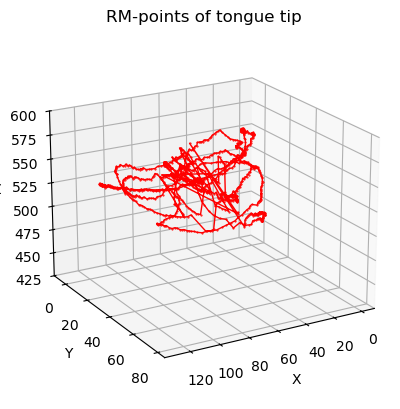

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

# 定义函数来加载3D点
def load_3d_points(file_path):
    points = []
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y, z = line.strip().split()
            points.append([float(x), float(y), float(z)])
    return np.array(points)

# 定义去除离群点的函数
def remove_outliers(points, threshold=3):
    z_scores = np.abs(stats.zscore(points))
    return points[(z_scores < threshold).all(axis=1)]

# 加载3D点
tongue_points = load_3d_points('./tongue_3d_pointsRM.txt')

# 去除离群点
filtered_points = remove_outliers(tongue_points)

# 分别获取过滤后的X、Y、Z坐标
X_filtered = filtered_points[:, 0]
Y_filtered = filtered_points[:, 1]
Z_filtered = filtered_points[:, 2]

# 创建3D绘图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制去除离群点后的舌尖点，设置线宽为1，圆点大小为2
ax.plot(X_filtered, Y_filtered, Z_filtered, c='r', marker='o', lw=1, ms=0.5)
# ax.plot(X_filtered, Y_filtered, Z_filtered, c='r', marker='o') 

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 绘制坐标轴箭头
ax.quiver(0, 0, 0, 1, 0, 0, color='r', length=10, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 1, 0, color='g', length=10, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 0, 1, color='b', length=10, arrow_length_ratio=0.1)

# 添加坐标轴标签
ax.text(10, 0, 0, 'X', color='r')
ax.text(0, 10, 0, 'Y', color='g')
ax.text(0, 0, 10, 'Z', color='b')

# 设置标题
plt.title('RM-points of tongue tip ')

ax.set_zlim(425, 600)
# 调整视角，使得 X 轴正对你
ax.view_init(elev=20, azim=60)

# 显示图形
plt.show()


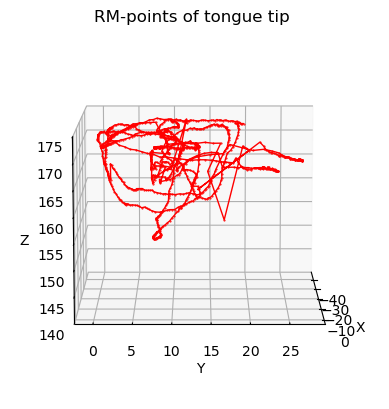

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

# 定义函数来加载3D点
def load_3d_points(file_path):
    points = []
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y, z = line.strip().split()
            points.append([float(x), float(y), float(z)])
    return np.array(points)

# 定义去除离群点的函数
def remove_outliers(points, threshold=3):
    z_scores = np.abs(stats.zscore(points))
    return points[(z_scores < threshold).all(axis=1)]

# 加载3D点
tongue_points = load_3d_points('./tongue_3d_pointsLR.txt')

# 去除离群点
filtered_points = remove_outliers(tongue_points)

# 分别获取过滤后的X、Y、Z坐标
X_filtered = filtered_points[:, 0]
Y_filtered = filtered_points[:, 1]
Z_filtered = filtered_points[:, 2]

# 创建3D绘图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制去除离群点后的舌尖点，设置线宽为1，圆点大小为2
ax.plot(X_filtered, Y_filtered, Z_filtered, c='r', marker='o', lw=1, ms=0.5)
# ax.plot(X_filtered, Y_filtered, Z_filtered, c='r', marker='o') 

# 设置坐标轴标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 绘制坐标轴箭头
ax.quiver(0, 0, 0, 1, 0, 0, color='r', length=10, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 1, 0, color='g', length=10, arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 0, 1, color='b', length=10, arrow_length_ratio=0.1)

# 添加坐标轴标签
ax.text(10, 0, 0, 'X', color='r')
ax.text(0, 10, 0, 'Y', color='g')
ax.text(0, 0, 10, 'Z', color='b')

# 设置标题
plt.title('RM-points of tongue tip ')

ax.set_zlim(140, 175)
# 调整视角，使得 X 轴正对你
ax.view_init(elev=10, azim=0)

# 显示图形
plt.show()


### draw the error between different views

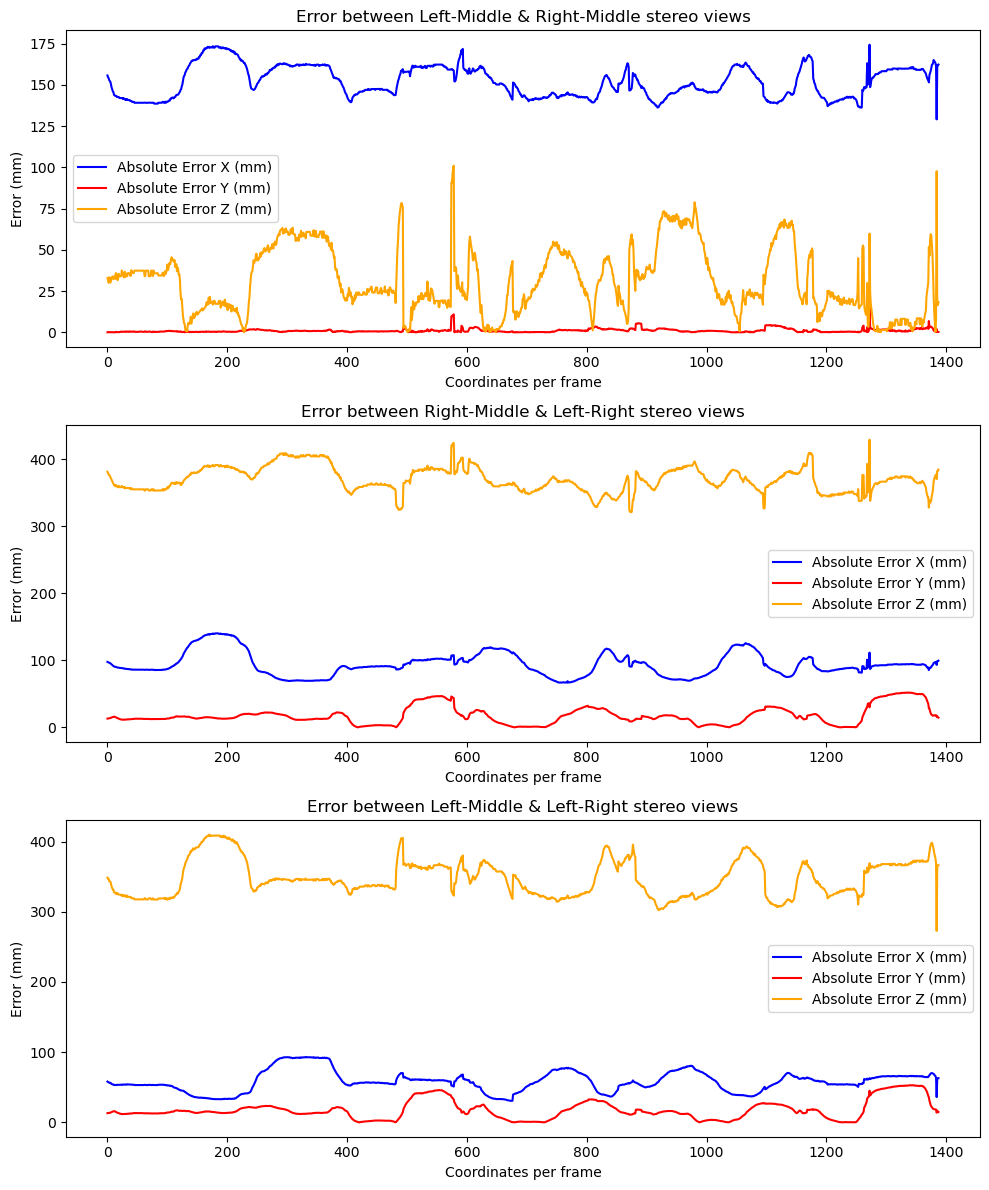

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 定义提取坐标的函数，返回帧号和对应的 (X, Y, Z) 坐标
def extract_frame_and_coordinates(points):
    frames = points[:, 0].astype(int)
    X = points[:, 1]
    Y = points[:, 2]
    Z = points[:, 3]
    return frames, X, Y, Z

# 定义去除离群点的函数，使用 z-score
def remove_outliers(points, threshold=3):
    z_scores = np.abs(stats.zscore(points[:, 1:]))  # 只对坐标 (X, Y, Z) 去除离群点
    return points[(z_scores < threshold).all(axis=1)]

# 加载 3D 点的函数
def load_3d_points(file_path):
    points = []
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y, z = line.strip().split()
            points.append([int(frame), float(x), float(y), float(z)])
    return np.array(points)

# 加载数据
file_left_middle = 'tongue_3d_pointsLM.txt'
file_right_middle = 'tongue_3d_pointsRM.txt'
file_left_right = 'tongue_3d_pointsLR.txt'

points_left_middle = load_3d_points(file_left_middle)
points_right_middle = load_3d_points(file_right_middle)
points_left_right = load_3d_points(file_left_right)

# 去除离群点
points_left_middle = remove_outliers(points_left_middle)
points_right_middle = remove_outliers(points_right_middle)
points_left_right = remove_outliers(points_left_right)

# 提取帧号和对应的坐标
frames_left_middle, X_left_middle, Y_left_middle, Z_left_middle = extract_frame_and_coordinates(points_left_middle)
frames_right_middle, X_right_middle, Y_right_middle, Z_right_middle = extract_frame_and_coordinates(points_right_middle)
frames_left_right, X_left_right, Y_left_right, Z_left_right = extract_frame_and_coordinates(points_left_right)

# 找到共有的帧号
common_frames = np.intersect1d(np.intersect1d(frames_left_middle, frames_right_middle), frames_left_right)

# 对齐数据，根据共有帧号取出对应帧的坐标
def align_frames(frames, X, Y, Z, common_frames):
    indices = np.isin(frames, common_frames)
    return X[indices], Y[indices], Z[indices]

X_left_middle_aligned, Y_left_middle_aligned, Z_left_middle_aligned = align_frames(frames_left_middle, X_left_middle, Y_left_middle, Z_left_middle, common_frames)
X_right_middle_aligned, Y_right_middle_aligned, Z_right_middle_aligned = align_frames(frames_right_middle, X_right_middle, Y_right_middle, Z_right_middle, common_frames)
X_left_right_aligned, Y_left_right_aligned, Z_left_right_aligned = align_frames(frames_left_right, X_left_right, Y_left_right, Z_left_right, common_frames)

# 计算误差
# 1. Left-Middle & Right-Middle
error_x_lm_rm = np.abs(X_left_middle_aligned - X_right_middle_aligned)
error_y_lm_rm = np.abs(Y_left_middle_aligned - Y_right_middle_aligned)
error_z_lm_rm = np.abs(Z_left_middle_aligned - Z_right_middle_aligned)

# 2. Right-Middle & Left-Right
error_x_rm_lr = np.abs(X_right_middle_aligned - X_left_right_aligned)
error_y_rm_lr = np.abs(Y_right_middle_aligned - Y_left_right_aligned)
error_z_rm_lr = np.abs(Z_right_middle_aligned - Z_left_right_aligned)

# 3. Left-Middle & Left-Right
error_x_lm_lr = np.abs(X_left_middle_aligned - X_left_right_aligned)
error_y_lm_lr = np.abs(Y_left_middle_aligned - Y_left_right_aligned)
error_z_lm_lr = np.abs(Z_left_middle_aligned - Z_left_right_aligned)

# 绘图
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Left-Middle & Right-Middle
ax1.plot(error_x_lm_rm, label='Absolute Error X (mm)', color='blue')
ax1.plot(error_y_lm_rm, label='Absolute Error Y (mm)', color='red')
ax1.plot(error_z_lm_rm, label='Absolute Error Z (mm)', color='orange')
ax1.set_title('Error between Left-Middle & Right-Middle stereo views')
ax1.set_xlabel('Coordinates per frame')
ax1.set_ylabel('Error (mm)')
ax1.legend()

# Right-Middle & Left-Right
ax2.plot(error_x_rm_lr, label='Absolute Error X (mm)', color='blue')
ax2.plot(error_y_rm_lr, label='Absolute Error Y (mm)', color='red')
ax2.plot(error_z_rm_lr, label='Absolute Error Z (mm)', color='orange')
ax2.set_title('Error between Right-Middle & Left-Right stereo views')
ax2.set_xlabel('Coordinates per frame')
ax2.set_ylabel('Error (mm)')
ax2.legend()

# Left-Middle & Left-Right
ax3.plot(error_x_lm_lr, label='Absolute Error X (mm)', color='blue')
ax3.plot(error_y_lm_lr, label='Absolute Error Y (mm)', color='red')
ax3.plot(error_z_lm_lr, label='Absolute Error Z (mm)', color='orange')
ax3.set_title('Error between Left-Middle & Left-Right stereo views')
ax3.set_xlabel('Coordinates per frame')
ax3.set_ylabel('Error (mm)')
ax3.legend()

plt.tight_layout()
plt.show()


## obtain the transformed 3d position by using LM camera system

Frame 1:
Origin (Nose Tip): [ -4.12735128 -10.9007225  216.31260681]
X Axis (Normal to cheek plane): [-0.26377655 -0.91222085  0.31348852]
Y Axis (From left cheek to right cheek): [-0.82167191  0.04226337 -0.56839166]
Z Axis (Cross product of X and Y): [ 0.50524965 -0.4075131  -0.76069433]
Frame 2:
Origin (Nose Tip): [ -4.12386227 -10.81800747 215.98568726]
X Axis (Normal to cheek plane): [-0.27335495 -0.90548731  0.32460715]
Y Axis (From left cheek to right cheek): [-0.82129209  0.04402664 -0.56880661]
Z Axis (Cross product of X and Y): [ 0.5007558  -0.42208339 -0.75570447]
Frame 3:
Origin (Nose Tip): [ -4.12386227 -10.81800747 215.98568726]
X Axis (Normal to cheek plane): [-0.26597984 -0.90952037  0.31941732]
Y Axis (From left cheek to right cheek): [-0.82144112  0.04044313 -0.56885748]
Z Axis (Cross product of X and Y): [ 0.50446923 -0.41368714 -0.75787449]
Frame 4:
Origin (Nose Tip): [ -4.12386227 -10.81800747 215.98568726]
X Axis (Normal to cheek plane): [-0.26597984 -0.90952037  

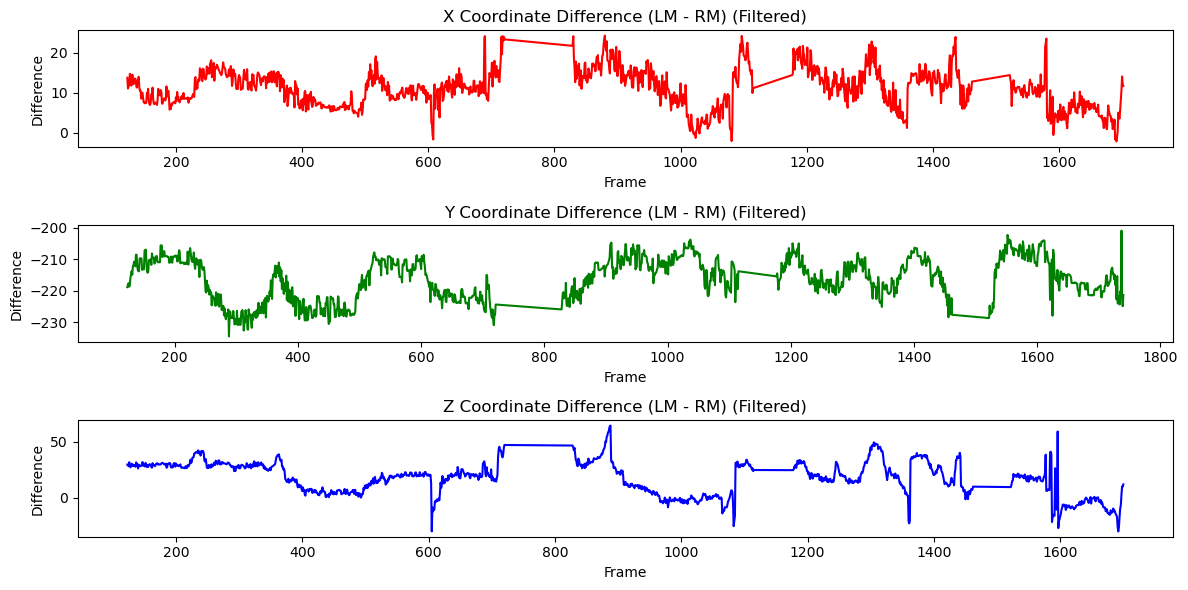

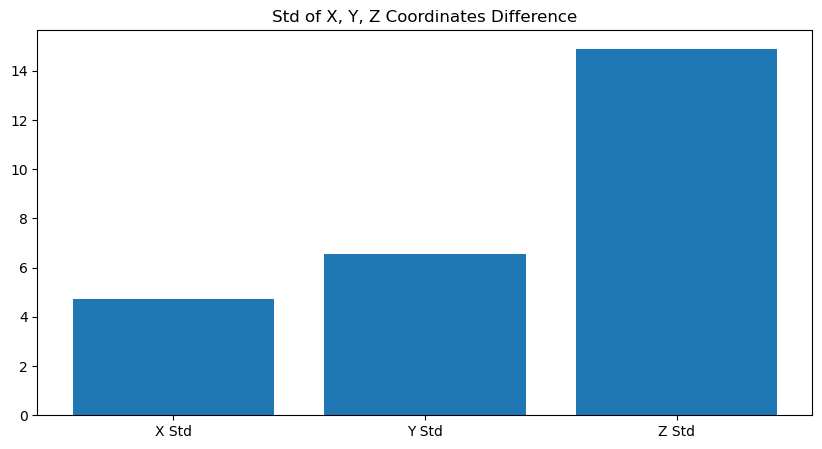

In [33]:
# 通过LM RM LF三个系统建立的3D参考坐标系，我需要计算舌尖点的3D坐标的X,Y,Z的坐标方差，计算每一帧的方差，然后绘制出来
# 首先是第一个LM系统的参考坐标系
import numpy as np

# 加载 3D 点的函数
def load_3d_points(file_path):
    points = {}
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y, z = line.strip().split()
            points[int(frame)] = np.array([float(x), float(y), float(z)])
    return points

# 加载 3D 坐标点
forehead_points = load_3d_points('./Points/3d_forehead_points_LM.txt')
nose_points = load_3d_points('./Points/3d_nose_points_LM.txt')
right_cheek_points = load_3d_points('./Points/3d_right_cheek_points_LM.txt')
left_cheek_points = load_3d_points('./Points/3d_left_cheek_points_LM.txt')

# 获取所有共同的帧号
common_frames = set(forehead_points.keys()) & set(nose_points.keys()) & set(right_cheek_points.keys()) & set(left_cheek_points.keys())

# 定义字典来存储每帧的面部参考坐标系
reference_coordinate_systems = {}
reference_coordinate_systems_copy = {}

# 对每一帧动态计算坐标系
for frame in sorted(common_frames):
    # 提取对应帧的点
    forehead_pt = forehead_points[frame]
    nose_pt = nose_points[frame]  # 作为坐标系的原点
    right_cheek_pt = right_cheek_points[frame]
    left_cheek_pt = left_cheek_points[frame]

    # Y 轴: 从左脸颊到右脸颊的向量
    y_axis = right_cheek_pt - left_cheek_pt
    y_axis = y_axis / np.linalg.norm(y_axis)  # 归一化

    # X 轴: 通过法向量计算
    # 使用额头、右脸颊、左脸颊点创建平面，计算该平面的法向量作为 X 轴
    cheek_plane_normal = np.cross(right_cheek_pt - nose_pt, left_cheek_pt - nose_pt)
    x_axis = cheek_plane_normal / np.linalg.norm(cheek_plane_normal)  # 归一化

    # Z 轴: X 轴和 Y 轴的叉积
    z_axis = np.cross(x_axis, y_axis)
    z_axis = z_axis / np.linalg.norm(z_axis)  # 归一化

    # 将每帧的坐标系存储起来
    reference_coordinate_systems[frame] = {
        'origin': nose_pt,
        'x_axis': x_axis,
        'y_axis': y_axis,
        'z_axis': z_axis
    }

    # 输出每帧的参考坐标系
    print(f"Frame {frame}:")
    print(f"Origin (Nose Tip): {nose_pt}")
    print(f"X Axis (Normal to cheek plane): {x_axis}")
    print(f"Y Axis (From left cheek to right cheek): {y_axis}")
    print(f"Z Axis (Cross product of X and Y): {z_axis}")
    print("="*50)

# 现在，你可以利用 `reference_coordinate_systems` 将其他 3D 点转换到每一帧的参考坐标系中。
# 读取舌尖点在LM系统下的3D坐标 把该坐标转换到我建立的参考坐标系中，算出每一帧对应的X,Y,Z坐标然后存储到字典里
tongue_points = load_3d_points('./tongue_3d_pointsLM.txt')

# 存储每一帧中舌尖点在参考坐标系下的 X、Y、Z 坐标
tongue_transformed_coords = {}
tongue_transformed_coords_copy = {}


# 对每一帧，将舌尖点坐标转换到参考坐标系
for frame in sorted(common_frames):
    if frame not in tongue_points:
        continue

    tongue_pt = tongue_points[frame]

    # 获取该帧的参考坐标系
    ref_coord = reference_coordinate_systems[frame]
    origin = ref_coord['origin']
    x_axis = ref_coord['x_axis']
    y_axis = ref_coord['y_axis']
    z_axis = ref_coord['z_axis']

    # 计算舌尖点相对于鼻尖点（原点）的向量
    tongue_vector = tongue_pt - origin

    # 计算舌尖点在参考坐标系中的 X, Y, Z 坐标
    tongue_x = np.dot(tongue_vector, x_axis)  # 在 X 轴上的投影
    tongue_y = np.dot(tongue_vector, y_axis)  # 在 Y 轴上的投影
    tongue_z = np.dot(tongue_vector, z_axis)  # 在 Z 轴上的投影

    # 存储转换后的坐标
    tongue_transformed_coords[frame] = (tongue_x, tongue_y, tongue_z)

    # 输出每帧的转换结果
    print(f"Frame {frame}: Tongue Tip in Face-Reference Coordinate System: X: {tongue_x}, Y: {tongue_y}, Z: {tongue_z}")

# 将结果保存到文件中
with open('./3d_tongue_transformed_LM.txt', 'w') as f:
    for frame, (tongue_x, tongue_y, tongue_z) in tongue_transformed_coords.items():
        f.write(f"{frame} {tongue_x} {tongue_y} {tongue_z}\n")

print("LM Tongue 3D coordinates in reference coordinate system saved successfully.")

reference_coordinate_systems_copy = reference_coordinate_systems.copy()

print('------------------------------')

forehead_points = load_3d_points('./Points/3d_forehead_points_RM.txt')
nose_points = load_3d_points('./Points/3d_nose_points_RM.txt')
right_cheek_points = load_3d_points('./Points/3d_right_cheek_points_RM.txt')
left_cheek_points = load_3d_points('./Points/3d_left_cheek_points_RM.txt')

# 获取所有共同的帧号
common_frames = set(forehead_points.keys()) & set(nose_points.keys()) & set(right_cheek_points.keys()) & set(left_cheek_points.keys())

# 定义字典来存储每帧的面部参考坐标系
reference_coordinate_systems = {}

# 对每一帧动态计算坐标系
for frame in sorted(common_frames):
    # 提取对应帧的点
    forehead_pt = forehead_points[frame]
    nose_pt = nose_points[frame]  # 作为坐标系的原点
    right_cheek_pt = right_cheek_points[frame]
    left_cheek_pt = left_cheek_points[frame]

    # Y 轴: 从左脸颊到右脸颊的向量
    y_axis = right_cheek_pt - left_cheek_pt
    y_axis = y_axis / np.linalg.norm(y_axis)  # 归一化

    # X 轴: 通过法向量计算
    # 使用额头、右脸颊、左脸颊点创建平面，计算该平面的法向量作为 X 轴
    cheek_plane_normal = np.cross(right_cheek_pt - nose_pt, left_cheek_pt - nose_pt)
    x_axis = cheek_plane_normal / np.linalg.norm(cheek_plane_normal)  # 归一化

    # Z 轴: X 轴和 Y 轴的叉积
    z_axis = np.cross(x_axis, y_axis)
    z_axis = z_axis / np.linalg.norm(z_axis)  # 归一化

    # 将每帧的坐标系存储起来
    reference_coordinate_systems[frame] = {
        'origin': nose_pt,
        'x_axis': x_axis,
        'y_axis': y_axis,
        'z_axis': z_axis
    }

    # 输出每帧的参考坐标系
    print(f"Frame {frame}:")
    print(f"Origin (Nose Tip): {nose_pt}")
    print(f"X Axis (Normal to cheek plane): {x_axis}")
    print(f"Y Axis (From left cheek to right cheek): {y_axis}")
    print(f"Z Axis (Cross product of X and Y): {z_axis}")
    print("="*50)

# 现在，你可以利用 `reference_coordinate_systems` 将其他 3D 点转换到每一帧的参考坐标系中。
# 读取舌尖点在RM系统下的3D坐标 把该坐标转换到我建立的参考坐标系中，算出每一帧对应的X,Y,Z坐标然后存储到字典里
tongue_points = load_3d_points('./tongue_3d_pointsRM.txt')

# 存储每一帧中舌尖点在参考坐标系下的 X、Y、Z 坐标
tongue_transformed_coords = {}

# 对每一帧，将舌尖点坐标转换到参考坐标系
for frame in sorted(common_frames):
    if frame not in tongue_points:
        continue

    tongue_pt = tongue_points[frame]

    # 获取该帧的参考坐标系
    ref_coord = reference_coordinate_systems[frame]
    origin = ref_coord['origin']
    x_axis = ref_coord['x_axis']
    y_axis = ref_coord['y_axis']
    z_axis = ref_coord['z_axis']

    # 计算舌尖点相对于鼻尖点（原点）的向量
    tongue_vector = tongue_pt - origin

    # 计算舌尖点在参考坐标系中的 X, Y, Z 坐标
    tongue_x = np.dot(tongue_vector, x_axis)  # 在 X 轴上的投影
    tongue_y = np.dot(tongue_vector, y_axis)  # 在 Y 轴上的投影
    tongue_z = np.dot(tongue_vector, z_axis)  # 在 Z 轴上的投影

    # 存储转换后的坐标
    tongue_transformed_coords[frame] = (tongue_x, tongue_y, tongue_z)

    # 输出每帧的转换结果
    print(f"Frame {frame}: Tongue Tip in Face-Reference Coordinate System: X: {tongue_x}, Y: {tongue_y}, Z: {tongue_z}")

# 将结果保存到文件中
with open('./3d_tongue_transformed_RM.txt', 'w') as f:
    for frame, (tongue_x, tongue_y, tongue_z) in tongue_transformed_coords.items():
        f.write(f"{frame} {tongue_x} {tongue_y} {tongue_z}\n")

print("RM Tongue 3D coordinates in reference coordinate system saved successfully.")

# 现在你可以计算 LM 和 RM 系统下舌尖点每一帧的 X、Y、Z 坐标的坐标差并绘制出来
tongue_points_LM = load_3d_points('./3d_tongue_transformed_LM.txt')
tongue_points_RM = load_3d_points('./3d_tongue_transformed_RM.txt')

common_frames = set(tongue_points_LM.keys()) & set(tongue_points_RM.keys())

# 存储差异
x_diffs = []
y_diffs = []
z_diffs = []

# 对每一帧，计算 LM 和 RM 系统下的 X、Y、Z 坐标差异
for frame in sorted(common_frames):
    # 获取 LM 和 RM 系统下舌尖点的 3D 坐标
    tongue_LM = tongue_points_LM[frame]
    tongue_RM = tongue_points_RM[frame]

    # 计算 X, Y, Z 坐标的差异
    x_diff = tongue_LM[0] - tongue_RM[0]
    y_diff = tongue_LM[1] - tongue_RM[1]
    z_diff = tongue_LM[2] - tongue_RM[2]

    x_diffs.append(x_diff)
    y_diffs.append(y_diff)
    z_diffs.append(z_diff)

# 定义 IQR 方法去除离群值
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return [x for x in data if lower_bound <= x <= upper_bound]

# 去除 X, Y, Z 坐标差异中的离群值
x_diffs_filtered = remove_outliers(x_diffs)
y_diffs_filtered = remove_outliers(y_diffs)
z_diffs_filtered = remove_outliers(z_diffs)

# 计算去除离群值后的 X, Y, Z 坐标差异的方差
x_variance_filtered = np.std(x_diffs_filtered)
y_variance_filtered = np.std(y_diffs_filtered)
z_variance_filtered = np.std(z_diffs_filtered)

# 打印去除离群值后的方差结果
print(f"Filtered Variance of X coordinates difference: {x_variance_filtered}")
print(f"Filtered Variance of Y coordinates difference: {y_variance_filtered}")
print(f"Filtered Variance of Z coordinates difference: {z_variance_filtered}")

# 绘制去除离群值后的 X, Y, Z 坐标差异随帧数的变化
frames = sorted(common_frames)

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(frames[:len(x_diffs_filtered)], x_diffs_filtered, label='X Difference', color='r')
plt.title('X Coordinate Difference (LM - RM) (Filtered)')
plt.xlabel('Frame')
plt.ylabel('Difference')

plt.subplot(3, 1, 2)
plt.plot(frames[:len(y_diffs_filtered)], y_diffs_filtered, label='Y Difference', color='g')
plt.title('Y Coordinate Difference (LM - RM) (Filtered)')
plt.xlabel('Frame')
plt.ylabel('Difference')

plt.subplot(3, 1, 3)
plt.plot(frames[:len(z_diffs_filtered)], z_diffs_filtered, label='Z Difference', color='b')
plt.title('Z Coordinate Difference (LM - RM) (Filtered)')
plt.xlabel('Frame')
plt.ylabel('Difference')

plt.tight_layout()
plt.show()

# 绘制去除离群值后的方差图
plt.figure(figsize=(10, 5))
plt.bar(['X Std', 'Y Std', 'Z Std'], [x_variance_filtered, y_variance_filtered, z_variance_filtered])
plt.title('Std of X, Y, Z Coordinates Difference')
plt.show()

In [37]:
# example video in 3D reference coordinate system
import cv2 as cv
import numpy as np

R = R_LM  # 左相机相对于中间相机的旋转矩阵
T = T_LM  # 左相机相对于中间相机的平移向量

# 加载 2D 点的函数
def load_2d_points(file_path):
    points = {}
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y = line.strip().split()
            points[int(frame)] = np.array([float(x), float(y)])
    return points

# 加载舌尖和鼻尖的 2D 坐标
tongue_points = load_2d_points('./Points/tongue_LeftTracking_L1.txt')
nose_tip_points = load_2d_points('./Points/LandmarksLeft/nose_tip_points.txt')

# 加载左相机的视频
cap = cv.VideoCapture('./subject1/proefpersoon 1.2_L.avi')

# 设置视频帧的索引
frame_index = 0

# 定义单位向量的长度，用于显示 X、Y、Z 轴在图像中的投影
axis_length = 50

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_index += 1

    # 检查当前帧是否有对应的鼻尖点和参考坐标系
    if frame_index in nose_tip_points and frame_index in reference_coordinate_systems_copy:
        nose_tip_2d = nose_tip_points[frame_index]

        # 获取当前帧的参考坐标系
        ref_coord = reference_coordinate_systems_copy[frame_index]
        origin_3d = ref_coord['origin']  # 3D 原点
        x_axis = ref_coord['x_axis']  # 3D X 轴方向向量
        y_axis = ref_coord['y_axis']  # 3D Y 轴方向向量
        z_axis = ref_coord['z_axis']  # 3D Z 轴方向向量

        # 定义坐标轴的 3D 端点
        axis_points_3d = np.array([
            origin_3d,                       # 原点
            origin_3d + x_axis * axis_length,  # X 轴终点
            origin_3d + y_axis * axis_length,  # Y 轴终点
            origin_3d + z_axis * axis_length   # Z 轴终点
        ], dtype='double')

        # 将 3D 点转换为 (N, 1, 3) 形状，适合 projectPoints
        axis_points_3d = axis_points_3d.reshape(-1, 1, 3)

        # 使用 projectPoints 将 3D 点投影到 2D 图像上
        axis_points_2d, _ = cv.projectPoints(axis_points_3d, R, T, mtxL, distL)
        axis_points_2d = axis_points_2d.reshape(-1, 2)

        # 将点转换为整数以便绘制
        origin_2d = tuple(axis_points_2d[0].astype(int))
        x_end_2d = tuple(axis_points_2d[1].astype(int))
        y_end_2d = tuple(axis_points_2d[2].astype(int))
        z_end_2d = tuple(axis_points_2d[3].astype(int))

        # 绘制坐标轴
        cv.line(frame, origin_2d, x_end_2d, (0, 0, 255), 2)  # X 轴红色
        cv.line(frame, origin_2d, y_end_2d, (0, 255, 0), 2)  # Y 轴绿色
        cv.line(frame, origin_2d, z_end_2d, (255, 0, 0), 2)  # Z 轴蓝色

        if frame_index in tongue_points:
            tongue_2d = tongue_points[frame_index]
            cv.circle(frame, tuple(tongue_2d.astype(int)), 5, (255, 255, 0), -1)

    # 显示帧
    cv.imshow('Frame with Coordinate Axes', frame)

    # 按 'q' 键退出
    if cv.waitKey(20) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

In [ ]:
# example video in 3D reference coordinate system
import cv2 as cv
import numpy as np

R = R_RM  # 左相机相对于中间相机的旋转矩阵
T = T_RM  # 左相机相对于中间相机的平移向量

# 加载 2D 点的函数
def load_2d_points(file_path):
    points = {}
    with open(file_path, 'r') as f:
        for line in f:
            frame, x, y = line.strip().split()
            points[int(frame)] = np.array([float(x), float(y)])
    return points

# 加载舌尖和鼻尖的 2D 坐标
tongue_points = load_2d_points('./Points/tongue_LeftTracking_R1.txt')
nose_tip_points = load_2d_points('./Points/LandmarksRight/nose_tip_points.txt')

# 加载左相机的视频
cap = cv.VideoCapture('./subject1/proefpersoon 1.2_R.avi')

# 设置视频帧的索引
frame_index = 0

# 定义单位向量的长度，用于显示 X、Y、Z 轴在图像中的投影
axis_length = 50

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_index += 1

    # 检查当前帧是否有对应的鼻尖点和参考坐标系
    if frame_index in nose_tip_points and frame_index in reference_coordinate_systems_copy:
        nose_tip_2d = nose_tip_points[frame_index]

        # 获取当前帧的参考坐标系
        ref_coord = reference_coordinate_systems_copy[frame_index]
        origin_3d = ref_coord['origin']  # 3D 原点
        x_axis = ref_coord['x_axis']  # 3D X 轴方向向量
        y_axis = ref_coord['y_axis']  # 3D Y 轴方向向量
        z_axis = ref_coord['z_axis']  # 3D Z 轴方向向量

        # 定义坐标轴的 3D 端点
        axis_points_3d = np.array([
            origin_3d,                       # 原点
            origin_3d + x_axis * axis_length,  # X 轴终点
            origin_3d + y_axis * axis_length,  # Y 轴终点
            origin_3d + z_axis * axis_length   # Z 轴终点
        ], dtype='double')

        # 将 3D 点转换为 (N, 1, 3) 形状，适合 projectPoints
        axis_points_3d = axis_points_3d.reshape(-1, 1, 3)

        # 使用 projectPoints 将 3D 点投影到 2D 图像上
        axis_points_2d, _ = cv.projectPoints(axis_points_3d, R, T, mtxL, distL)
        axis_points_2d = axis_points_2d.reshape(-1, 2)

        # 将点转换为整数以便绘制
        origin_2d = tuple(axis_points_2d[0].astype(int))
        x_end_2d = tuple(axis_points_2d[1].astype(int))
        y_end_2d = tuple(axis_points_2d[2].astype(int))
        z_end_2d = tuple(axis_points_2d[3].astype(int))

        # 绘制坐标轴
        cv.line(frame, origin_2d, x_end_2d, (0, 0, 255), 2)  # X 轴红色
        cv.line(frame, origin_2d, y_end_2d, (0, 255, 0), 2)  # Y 轴绿色
        cv.line(frame, origin_2d, z_end_2d, (255, 0, 0), 2)  # Z 轴蓝色

        if frame_index in tongue_points:
            tongue_2d = tongue_points[frame_index]
            cv.circle(frame, tuple(tongue_2d.astype(int)), 5, (255, 255, 0), -1)

    # 显示帧
    cv.imshow('Frame with Coordinate Axes', frame)

    # 按 'q' 键退出
    if cv.waitKey(20) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()